# **HEART DISEASE CLUSTERING**

## **Project Overview**  

This project focuses on applying Unsupervised Machine Learning techniques to the Heart Disease dataset.
It serves as the second phase of the broader Heart Disease Analytics & Prediction initiative.

The first phase (already completed) included:

🔹 Extensive data cleaning and preprocessing

🔹 In-depth Exploratory Data Analysis (EDA)

🔹 Feature engineering and transformation

🔹 Supervised model development using Logistic Regression, Random Forest, XGBoost, and SVM

🔹 Model tuning & evaluation (ROC curves, metrics)

🔹 Final model deployment via Streamlit interface

Because of this, the dataset used in the clustering phase is already fully cleaned, explored, validated, and modeled.

This second phase uses the refined dataset to discover hidden patterns and natural groupings among patients that are not based on the heart-disease label.



- I applied three unsupervised clustering algorithms — KMeans, Agglomerative, and DBSCAN — to explore natural groupings in the heart disease dataset. The goal is to identify patterns and potential subgroups without using the target label (heart_disease).

## **Objectives**  

The primary objective of this unsupervised learning stage is to:

Identify naturally occurring clusters among patients based solely on clinical features to uncover hidden phenotypes, differentiate risk groups, support early intervention strategies and determine whether heart disease patterns emerge organically from the data without using labels.

Specifically, this phase aims to:

- Apply multiple clustering algorithms (KMeans, Agglomerative Hierarchical Clustering, DBSCAN)

- Compare cluster compositions and clinical profiles

- Generate cluster heatmaps to visualize feature intensities

- Interpret clusters in the context of cardiovascular risk

- Provide clinically meaningful insights that complement the supervised classification results

- Offer recommendations that could support clinicians, hospitals, or public-health interventions

This process helps answer questions like:

Do patients naturally form high-risk vs low-risk groups?

Can we identify groups that present similar symptoms even without labels?

Can clustering reveal patient archetypes that supervised learning might miss?


### **Dataset Description**  

| **Column**                | **Description**                                                                                                                                   |
| ------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| `age`                     | Age in years                                                                                                                                      |
| `sex`                     | Sex (1 = male, 0 = female)                                                                                                                        |
| `chest_pain_type`         | Chest pain type (**0** = typical angina, **1** = atypical angina, **2** = non-anginal pain, **3** = asymptomatic) *(original: `cp`)*              |
| `resting_bp`              | Resting blood pressure on hospital admission (mm Hg) *(original: `trestbps`)*                                                                     |
| `cholesterol`             | Serum cholesterol (mg/dl) *(original: `chol`)*                                                                                                    |
| `fasting_blood_sugar`     | Fasting blood sugar > 120 mg/dl (**1** = true, **0** = false) *(original: `fbs`)*                                                                 |
| `resting_ecg`             | Resting electrocardiographic results: **0** = normal, **1** = ST-T wave abnormality, **2** = left ventricular hypertrophy *(original: `restecg`)* |
| `max_heart_rate`          | Maximum heart rate achieved *(original: `thalach`)*                                                                                               |
| `exercise_induced_angina` | Exercise-induced angina (**1** = yes, **0** = no) *(original: `exang`)*                                                                           |
| `st_depression`           | ST depression induced by exercise relative to rest *(original: `oldpeak`)*                                                                        |
| `st_slope`                | Slope of the peak exercise ST segment: **0** = upsloping, **1** = flat, **2** = downsloping *(original: `slope`)*                                 |
| `num_major_vessels`       | Number of major vessels (0–3) colored by fluoroscopy *(original: `ca`)*                                                                           |
| `thalassemia`             | Thalassemia type: **1** = fixed defect, **2** = normal, **3** = reversible defect *(original: `thal`; 0 = invalid removed)*                       |
| `heart_disease`           | Diagnosis of heart disease (**0** = no disease, **1** = disease) *(original: `target`)*                                                           |


## **Imports and Installations**

In [1]:
pip install kneed


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing Standard Libraries
import numpy as np
import pandas as pd
import warnings
import joblib
import umap

# Imports for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # Optional: set default plot style

# Ignore warnings
warnings.filterwarnings("ignore")


# Imports for Preprocessing & Pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture


# Importing Machine Learning Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN


# Importing Evaluation Metrics
 
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

from kneed import KneeLocator


### **Load Clean Dataset from Previous Project**

In [4]:
file = ("heart_disease_cluster_df.csv")
cluster_df = pd.read_csv(file)

### View Dataset

In [5]:
cluster_df.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,heart_disease
0,63,Male,Asymptomatic,145,233,True (>120 mg/dl),Normal,150,No,2.3,Upsloping,0,Fixed Defect,1
1,37,Male,Non-Anginal Pain,130,250,False (<=120 mg/dl),ST-T Wave Abnormality,187,No,3.5,Upsloping,0,Normal,1
2,41,Female,Atypical Angina,130,204,False (<=120 mg/dl),Normal,172,No,1.4,Downsloping,0,Normal,1
3,56,Male,Atypical Angina,120,236,False (<=120 mg/dl),ST-T Wave Abnormality,178,No,0.8,Downsloping,0,Normal,1
4,57,Female,Typical Angina,120,354,False (<=120 mg/dl),ST-T Wave Abnormality,163,Yes,0.6,Downsloping,0,Normal,1


## **Data Preparation**

### **Drop Target**

In [6]:
# Drop target column (heart_disease)

X = cluster_df.drop(columns=['heart_disease'])
y = cluster_df['heart_disease']
print(f" Dropped target, features shape: {X.shape}")


 Dropped target, features shape: (296, 13)


### **Identify Feature Data Types**

In [7]:
# Identify feature types


num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Count of different datatypes
dtypes_count = X.dtypes.value_counts()
print("Count of Different Datatypes:\n", dtypes_count)


print(f"\nNumerical features: {num_features}")
print(f"Categorical features: {cat_features}")


Count of Different Datatypes:
 object     7
int64      5
float64    1
Name: count, dtype: int64

Numerical features: ['age', 'resting_bp', 'cholesterol', 'max_heart_rate', 'st_depression', 'num_major_vessels']
Categorical features: ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_ecg', 'exercise_induced_angina', 'st_slope', 'thalassemia']


In [8]:
# Check Data Types and Their Count

# Count of different datatypes
dtypes_count = X.dtypes.value_counts()
print("Count of Different Datatypes:\n", dtypes_count)

# Columns with object (categorical) datatype
object_dtypes = X.select_dtypes(include='object').columns
print("\nColumns with Object (Categorical) Datatype:\n", list(object_dtypes))

# Columns with int64 (integer) datatype
int64_dtypes = X.select_dtypes(include='int64').columns
print("\nColumns with int64 (Integer) Datatype:\n", list(int64_dtypes))

# Columns with float64 (floating point) datatype
float64_dtypes = X.select_dtypes(include='float64').columns
print("\nColumns with float64 (Floating Point) Datatype:\n", list(float64_dtypes))


Count of Different Datatypes:
 object     7
int64      5
float64    1
Name: count, dtype: int64

Columns with Object (Categorical) Datatype:
 ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_ecg', 'exercise_induced_angina', 'st_slope', 'thalassemia']

Columns with int64 (Integer) Datatype:
 ['age', 'resting_bp', 'cholesterol', 'max_heart_rate', 'num_major_vessels']

Columns with float64 (Floating Point) Datatype:
 ['st_depression']


## **Preprocessing Pipeline**

In [9]:

#  Define Numerical & Categorical Features


num_features = ['age', 'resting_bp', 'cholesterol',
                'max_heart_rate', 'st_depression', 'num_major_vessels']

cat_features = ['sex', 'chest_pain_type', 'fasting_blood_sugar',
                'resting_ecg', 'exercise_induced_angina',
                'st_slope', 'thalassemia']


#  Outlier Capping Function 

def cap_outliers_cluster(df):
    df = df.copy()
    for col in num_features:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower, upper=upper)
    return df



#  Build Numerical Pipeline (cap → scale)

num_transformer = Pipeline(steps=[
    ('cap', FunctionTransformer(cap_outliers_cluster, validate=False)),
    ('scaler', StandardScaler())
])



# Build Categorical Pipeline (one-hot encode)

cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)



# Combined Preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)


# Apply Full Pipeline


X_preprocessed = preprocessor.fit_transform(X)

print("Preprocessed data shape:", X_preprocessed.shape)


Preprocessed data shape: (296, 25)


## **Determine the Optimal Number of Clusters (k)**

### **Elbow Method to find Optimal k**

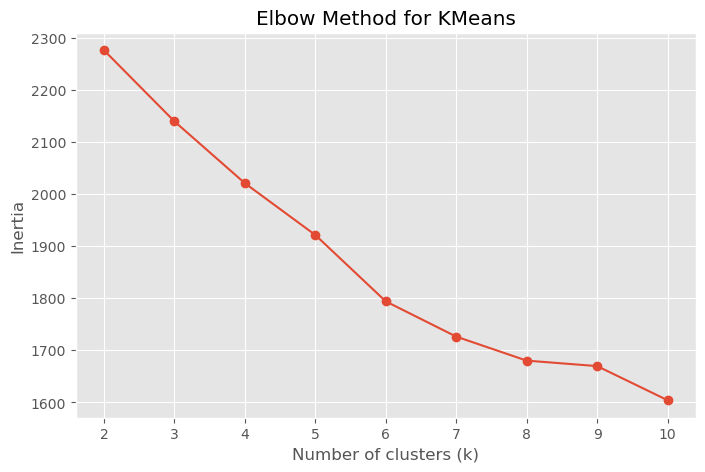

In [10]:


# Try k values from 2 to 10
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    inertia.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.show()


### **Elbow Method Vs. Silhouette Score for Optimal K**

Best k according to Elbow method: 6
Best k according to Silhouette score: 2


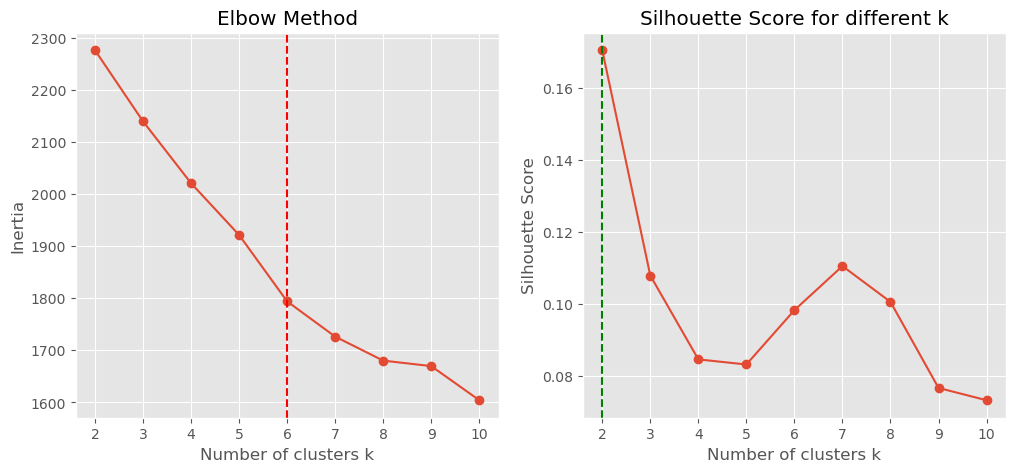

In [11]:


inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_preprocessed)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_preprocessed, labels))

# Elbow detection
kl = KneeLocator(K, inertia, curve="convex", direction="decreasing")
best_k_elbow = kl.elbow
best_k_silhouette = K[sil_scores.index(max(sil_scores))]

print(f"Best k according to Elbow method: {best_k_elbow}")
print(f"Best k according to Silhouette score: {best_k_silhouette}")

# Plotting for visualization
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.axvline(best_k_elbow, color='red', linestyle='--')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o')
plt.axvline(best_k_silhouette, color='green', linestyle='--')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different k')

plt.show()



### **Optimal k Summary**  

- The Elbow Method suggested **k = 6**, indicating potential finer subgroups, while the Silhouette Score suggested **k = 2**, showing the most cohesive and well-separated clusters. This means the data can be explored either as two broad groups or six more detailed subgroups, depending on whether the focus is general segmentation or deeper exploratory analysis.

## **CLUSTERING**

## **KMeans Clustering**

KMeans k=2: Silhouette=0.170, Calinski-Harabasz=65.5, Davies-Bouldin=2.076
KMeans k=6: Silhouette=0.098, Calinski-Harabasz=32.0, Davies-Bouldin=2.305


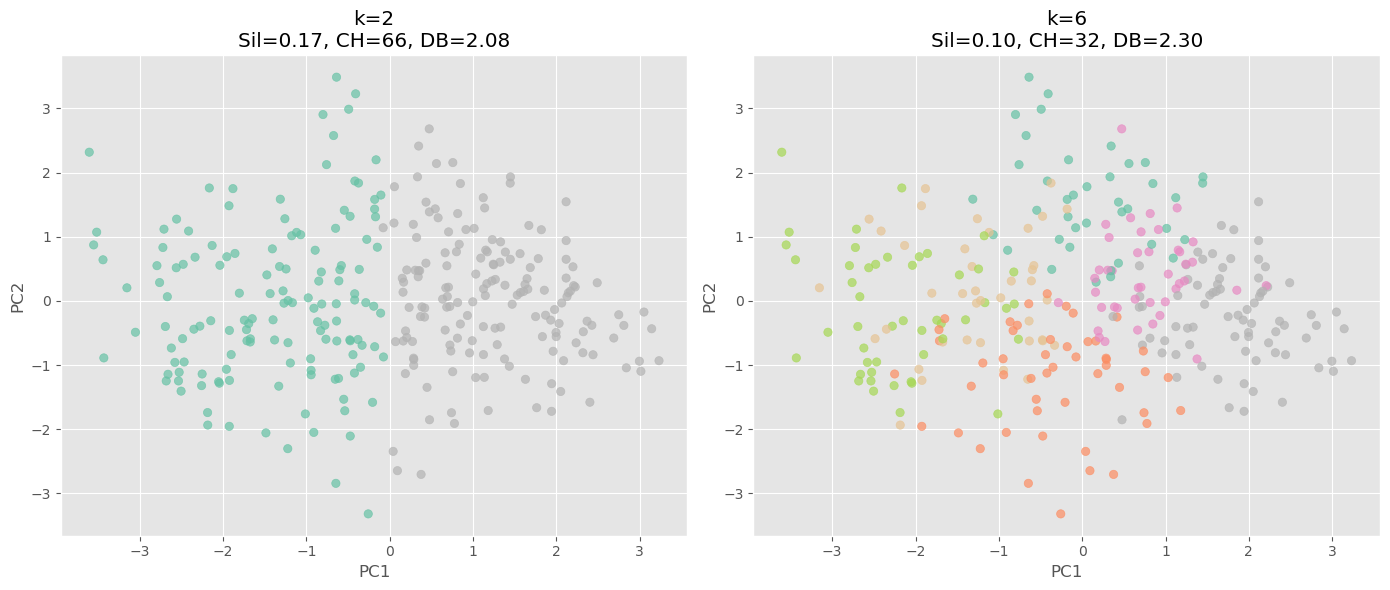

In [13]:
# Choose k values
k_values = [2, 6]

#  2D PCA for visualization 
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_preprocessed)

# Prepare figure with subplots
fig, axes = plt.subplots(1, len(k_values), figsize=(14,6))

for i, k in enumerate(k_values):
    #  Fit KMeans 
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_preprocessed)
    
    #  Compute metrics
    sil = silhouette_score(X_preprocessed, labels)
    ch = calinski_harabasz_score(X_preprocessed, labels)
    db = davies_bouldin_score(X_preprocessed, labels)
    
    print(f"KMeans k={k}: Silhouette={sil:.3f}, Calinski-Harabasz={ch:.1f}, Davies-Bouldin={db:.3f}")
    
    # Plot
    ax = axes[i]
    scatter = ax.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='Set2', alpha=0.7)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"k={k}\nSil={sil:.2f}, CH={ch:.0f}, DB={db:.2f}")

plt.tight_layout()
plt.show()



### **Insights**  

**1. Silhouette Score**

k=2 → 0.170

Low, but higher than k=6.

Indicates clusters are slightly better separated and cohesive than k=6.

k=6 → 0.098

Lower score → clusters are less well-defined, points are closer to cluster boundaries.

Suggests the data doesn’t naturally split into six distinct clusters.


- Silhouette favors k=2, meaning the coarse 2-cluster grouping makes more sense in terms of cluster cohesion and separation.

---

**2. Calinski-Harabasz Index**

k=2 → 65.5

k=6 → 32.0

Higher CH → better separation between clusters relative to within-cluster variance.

Again, k=2 is better.


- The 2-cluster solution is more compact and well-separated, confirming what the silhouette score suggests.

--- 

**3. Davies-Bouldin Index**

k=2 → 2.076

k=6 → 2.305

Lower DB → better clustering (less similarity between clusters).

k=2 has the lower value → better clustering.


- All three metrics consistently indicate that k=2 gives the more meaningful clusters.

k=6 produces finer subgroups but they are not very well-separated, so metrics drop.


 
**Overall Interpretation**

The 2-cluster solution likely reflects the most natural division in your heart disease dataset.

The 6-cluster solution may still reveal subtle subgroups, but they are less distinct, as the metrics suggest.

This is consistent with the Silhouette analysis earlier, where 2 had the highest score.

## **Agglomerative Clustering**

Agglomerative k=2: Silhouette=0.130, Calinski-Harabasz=51.4, Davies-Bouldin=2.309
Agglomerative k=6: Silhouette=0.088, Calinski-Harabasz=26.1, Davies-Bouldin=2.520


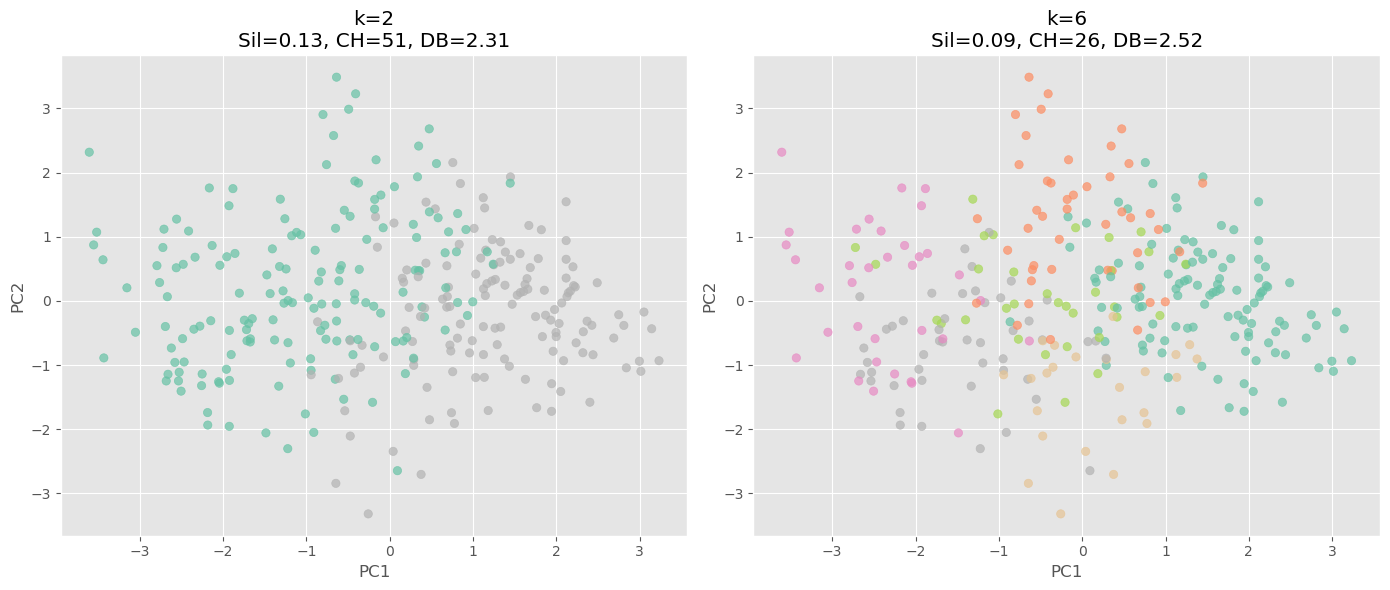

In [14]:


# k values to try
k_values = [2, 6]

#  2D PCA for visualization 
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_preprocessed)

# Prepare figure with subplots
fig, axes = plt.subplots(1, len(k_values), figsize=(14,6))

for i, k in enumerate(k_values):
    #  Fit Agglomerative Clustering 
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_preprocessed)
    
    # Compute metrics
    sil = silhouette_score(X_preprocessed, labels)
    ch = calinski_harabasz_score(X_preprocessed, labels)
    db = davies_bouldin_score(X_preprocessed, labels)
    
    print(f"Agglomerative k={k}: Silhouette={sil:.3f}, Calinski-Harabasz={ch:.1f}, Davies-Bouldin={db:.3f}")
    
    #  Plot 
    ax = axes[i]
    scatter = ax.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='Set2', alpha=0.7)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"k={k}\nSil={sil:.2f}, CH={ch:.0f}, DB={db:.2f}")

plt.tight_layout()
plt.show()


### **Insights**  

**1. Silhouette Score**

k=2 → 0.130

Low, but higher than k=6.

Indicates clusters are slightly better separated and cohesive than k=6.

k=6 → 0.088

Even lower → clusters are less well-defined, points are closer to boundaries.

- Agglomerative also favors k=2 for better cohesion and separation.

---

**2. Calinski-Harabasz Index**

k=2 → 51.4

k=6 → 26.1

- Higher CH → better separation relative to within-cluster variance.

- Again, k=2 is better, suggesting the 2-cluster solution is more compact and well-separated.

---

**3. Davies-Bouldin Index**

k=2 → 2.309

k=6 → 2.520

- Lower DB → better clustering.

- k=2 has the lower value → better clustering quality.

---

**Overall Interpretation**

Similar to KMeans: k=2 produces the most meaningful clusters.

k=6 produces smaller subgroups, but they are less distinct, as all three metrics drop.

Silhouette, CH, and DB all consistently indicate 2 clusters is the more natural separation.

## **DBSCAN**

DBSCAN: Silhouette=0.6240619606745299, Calinski-Harabasz=43.38972856515249, Davies-Bouldin=0.48613530719610243
Number of clusters (excluding noise): 2
Number of noise points: 275


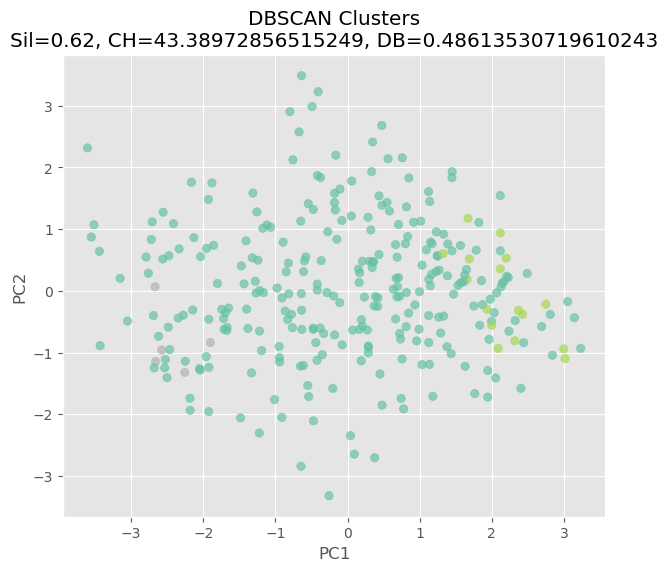

In [28]:


# 2D PCA for visualization 
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_preprocessed)

#  DBSCAN parameters
dbscan = DBSCAN(eps=1.5, min_samples=5) 
labels = dbscan.fit_predict(X_preprocessed)

#  Handle metrics only for valid clusters (ignore noise points) 
mask = labels != -1  # exclude noise points
if len(set(labels[mask])) > 1:  # need at least 2 clusters
    sil = silhouette_score(X_preprocessed[mask], labels[mask])
    ch = calinski_harabasz_score(X_preprocessed[mask], labels[mask])
    db = davies_bouldin_score(X_preprocessed[mask], labels[mask])
else:
    sil, ch, db = np.nan, np.nan, np.nan

print(f"DBSCAN: Silhouette={sil}, Calinski-Harabasz={ch}, Davies-Bouldin={db}")
print(f"Number of clusters (excluding noise): {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"Number of noise points: {list(labels).count(-1)}")

#  Visualization 
plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='Set2', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"DBSCAN Clusters\nSil={sil:.2f}, CH={ch}, DB={db}")
plt.show()


### **Insights**  

**1. Silhouette Score = 0.624**

Very high compared to KMeans and Agglomerative.

Indicates the two clusters found are extremely well-separated.

This is typical with DBSCAN: it ignores most points as noise, so the remaining points form very tight, dense clusters.

---

**2. Calinski-Harabasz = 43.39**

Lower than KMeans k=2 (65.5) and Agglomerative k=2 (51.4).

CH measures overall cluster separation and compactness relative to all points — here, most points are treated as noise, so the metric is lower.

---

**3. Davies-Bouldin = 0.486**

Much lower than KMeans (2.076) and Agglomerative (2.309).

Lower DB = better cluster separation → confirms the two non-noise clusters are very tight.

---

 **Number of clusters = 2**

DBSCAN automatically found 2 dense clusters, which aligns nicely with the “natural” 2-cluster pattern from KMeans/Agglomerative.

---

**Noise points = 275**

Out of 296 points, 275 were labeled as noise.

This explains why Silhouette is so high: the remaining points are extremely cohesive.

But it also means DBSCAN does not capture most of the data, only the densest regions.

### **Add Cluster Labels to the Original Dataframe**

In [16]:
# Copy original features (without target) for cluster assignment
df_clusters = cluster_df.copy()  # includes 'heart_disease'

#  KMeans k=2 
kmeans_2 = KMeans(n_clusters=2, random_state=42)
df_clusters['KMeans_k2'] = kmeans_2.fit_predict(X_preprocessed)

# Agglomerative k=2
agg_2 = AgglomerativeClustering(n_clusters=2)
df_clusters['Agglomerative_k2'] = agg_2.fit_predict(X_preprocessed)

# --- DBSCAN ---
dbscan = DBSCAN(eps=1.5, min_samples=5)
df_clusters['DBSCAN'] = dbscan.fit_predict(X_preprocessed)


### **Compute cluster-wise heart disease prevalence**

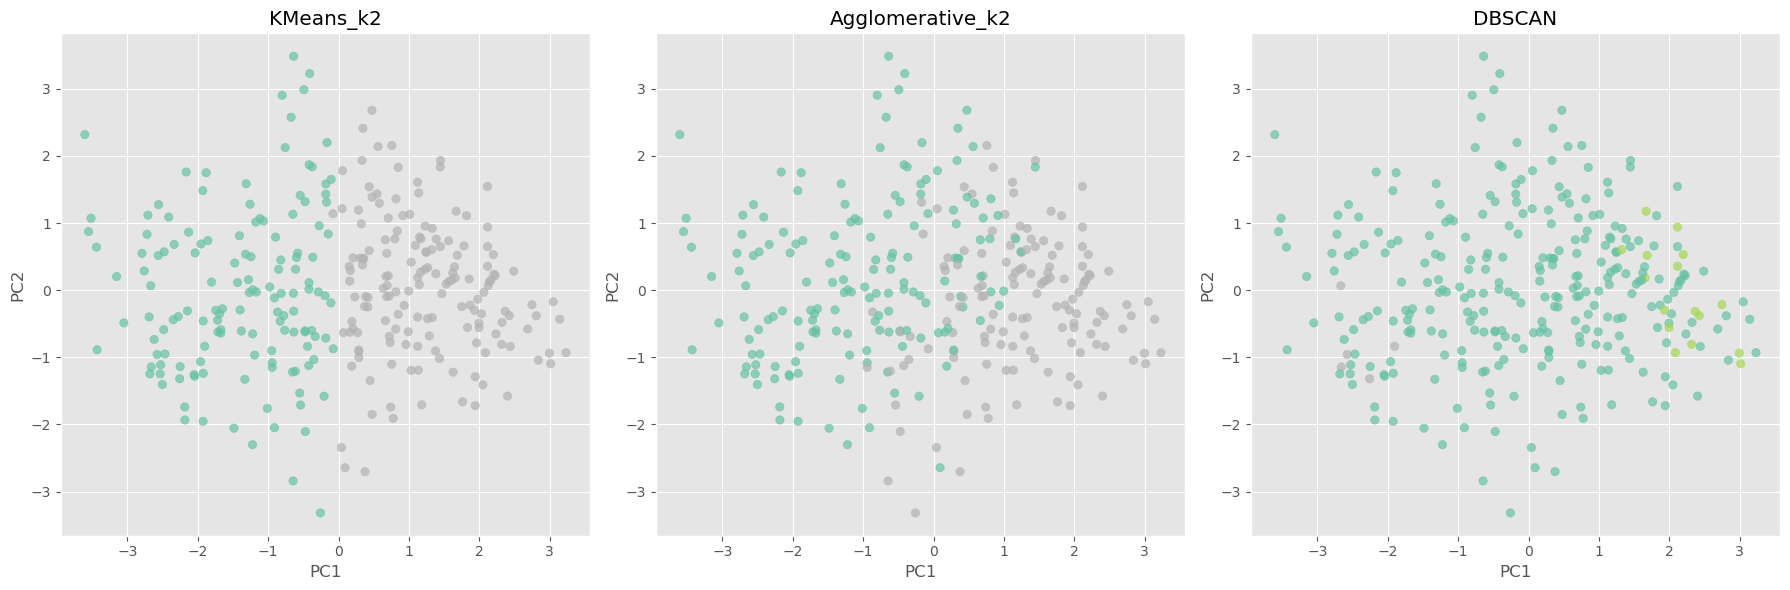

In [17]:

# 2D PCA for plotting
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_preprocessed)

cluster_cols = ['KMeans_k2', 'Agglomerative_k2', 'DBSCAN']
fig, axes = plt.subplots(1, 3, figsize=(18,6))

for i, col in enumerate(cluster_cols):
    ax = axes[i]
    scatter = ax.scatter(X_2d[:,0], X_2d[:,1], c=df_clusters[col], cmap='Set2', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()


### **Visualization of clusters (2D PCA) side by side**

In [18]:
def cluster_summary(df, cluster_col):
    summary = df.groupby(cluster_col)['heart_disease'].agg(
        count='count',
        heart_disease_sum='sum'
    )
    summary['prevalence (%)'] = (summary['heart_disease_sum'] / summary['count'] * 100).round(2)
    return summary

# KMeans k=2
print("KMeans k=2 Cluster Summary:")
print(cluster_summary(df_clusters, 'KMeans_k2'))

# Agglomerative k=2
print("\nAgglomerative k=2 Cluster Summary:")
print(cluster_summary(df_clusters, 'Agglomerative_k2'))

# DBSCAN
print("\nDBSCAN Cluster Summary (note: -1 = noise):")
print(cluster_summary(df_clusters, 'DBSCAN'))


KMeans k=2 Cluster Summary:
           count  heart_disease_sum  prevalence (%)
KMeans_k2                                          
0            139                 35           25.18
1            157                125           79.62

Agglomerative k=2 Cluster Summary:
                  count  heart_disease_sum  prevalence (%)
Agglomerative_k2                                          
0                   160                 55           34.38
1                   136                105           77.21

DBSCAN Cluster Summary (note: -1 = noise):
        count  heart_disease_sum  prevalence (%)
DBSCAN                                          
-1        275                145           52.73
 0         16                 15           93.75
 1          5                  0            0.00


### **Insights**  

**KMeans (k=2)**

- Cluster 1 has high prevalence (~80%), capturing patients with heart disease.

- Cluster 0 has low prevalence (~25%), capturing patients without heart disease.

- KMeans effectively separates high-risk vs low-risk groups, aligning with the binary nature of the target.

---

**Agglomerative (k=2)**  

Similar pattern to KMeans:

- Cluster 1 → high-risk group (~77% prevalence)

- Cluster 0 → low-risk group (~34% prevalence)

Slightly less separation than KMeans (Cluster 0 prevalence is a bit higher), but still captures broad grouping of patients.

---

**DBSCAN**  

DBSCAN identifies two dense clusters but labels most points as noise:

- Cluster 0 → almost all patients have heart disease (94%) → dense high-risk group

- Cluster 1 → all patients are healthy (0%) → very small low-risk cluster

Noise (-1) → majority of patients with mixed prevalence (52.7%) → not clustered

This confirms DBSCAN is very strict, capturing only the densest, most homogeneous subgroups, ignoring most of the data.


### **Summary**  

**KMeans and Agglomerative (k=2)**

- Both give two broad clusters, separating high-risk vs low-risk patients.

- KMeans slightly sharper in separation (prevalence differences).

- Useful for general clustering of all patients.



**DBSCAN**

- Identifies very tight high-risk and low-risk groups, but excludes most points as noise.

- Useful to detect extreme or dense subpopulations, potential outliers or very specific patterns.


**Cluster choice depends on goal:**

- Full dataset segmentation: KMeans k=2

- Focus on densest/extreme groups: DBSCAN

---

## **CLUSTER PROFILING**

### **Cluster Profiling (Mean of Features per Cluster)**

In [19]:
# Function to generate cluster profiling
def profile_clusters(df, cluster_col, feature_cols):
    """
    Computes mean values of features per cluster.
    """
    profile = df.groupby(cluster_col)[feature_cols].mean().round(2)
    return profile

# Define feature columns (numerical + categorical encoded as needed)
feature_cols = num_features + cat_features  # if categorical are encoded as numbers, else exclude

#  KMeans k=2 
print("KMeans k=2 Cluster Profile:")
print(profile_clusters(df_clusters, 'KMeans_k2', num_features))

#  Agglomerative k=2 
print("\nAgglomerative k=2 Cluster Profile:")
print(profile_clusters(df_clusters, 'Agglomerative_k2', num_features))

#  DBSCAN 
# Exclude noise (-1) if desired
print("\nDBSCAN Cluster Profile (excluding noise):")
print(profile_clusters(df_clusters[df_clusters['DBSCAN']!=-1], 'DBSCAN', num_features))


KMeans k=2 Cluster Profile:
             age  resting_bp  cholesterol  max_heart_rate  st_depression  \
KMeans_k2                                                                  
0          60.05      136.55       258.14          133.89           1.70   
1          49.63      127.23       237.43          163.43           0.49   

           num_major_vessels  
KMeans_k2                     
0                       1.17  
1                       0.24  

Agglomerative k=2 Cluster Profile:
                    age  resting_bp  cholesterol  max_heart_rate  \
Agglomerative_k2                                                   
0                 59.68      138.72       254.90          139.85   
1                 48.46      123.23       238.04          160.99   

                  st_depression  num_major_vessels  
Agglomerative_k2                                    
0                          1.46               1.13  
1                          0.58               0.15  

DBSCAN Cluster Profil

### **Categorical Feature Distribution Across Clusters**

In [21]:
def categorical_profile(df, cluster_col, cat_cols):
    """
    Computes value counts (%) of categorical features per cluster.
    """
    for col in cat_cols:
        print(f"\nFeature: {col}")
        pct = df.groupby(cluster_col)[col].value_counts(normalize=True).mul(100).round(1)
        print(pct.unstack(fill_value=0))
        
# Example for KMeans k=2
categorical_profile(df_clusters, 'KMeans_k2', cat_features)




Feature: sex
sex        Female  Male
KMeans_k2              
0            28.8  71.2
1            35.0  65.0

Feature: chest_pain_type
chest_pain_type  Asymptomatic  Atypical Angina  Non-Anginal Pain  \
KMeans_k2                                                          
0                         8.6              4.3              19.4   
1                         7.0             27.4              35.7   

chest_pain_type  Typical Angina  
KMeans_k2                        
0                          67.6  
1                          29.9  

Feature: fasting_blood_sugar
fasting_blood_sugar  False (<=120 mg/dl)  True (>120 mg/dl)
KMeans_k2                                                  
0                                   81.3               18.7
1                                   89.2               10.8

Feature: resting_ecg
resting_ecg  Left Ventricular Hypertrophy  Normal  ST-T Wave Abnormality
KMeans_k2                                                               
0                

### **Numerical Feature HeatMaps Across Clusters**

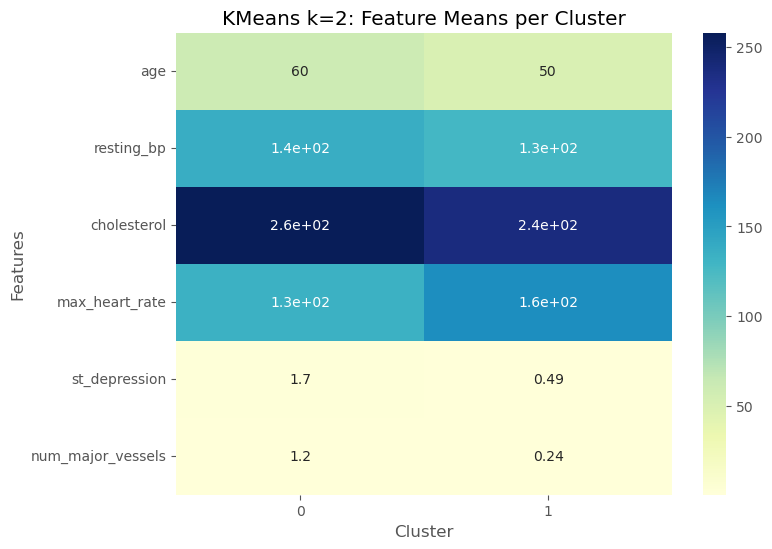

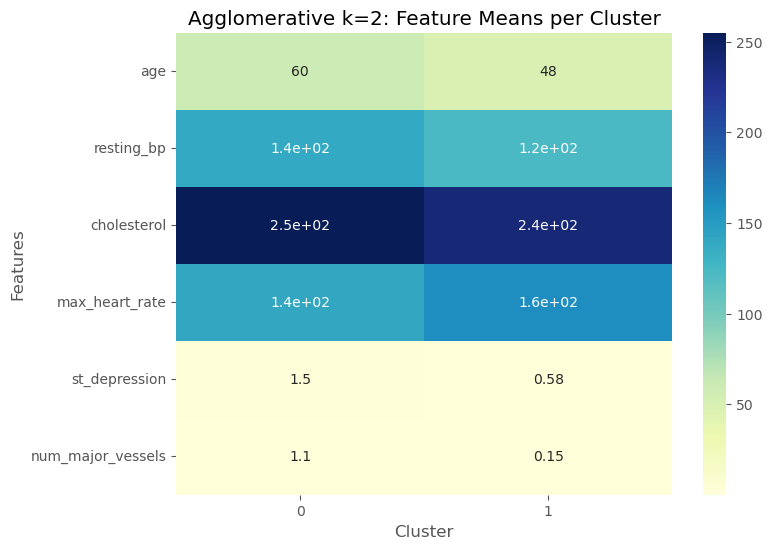

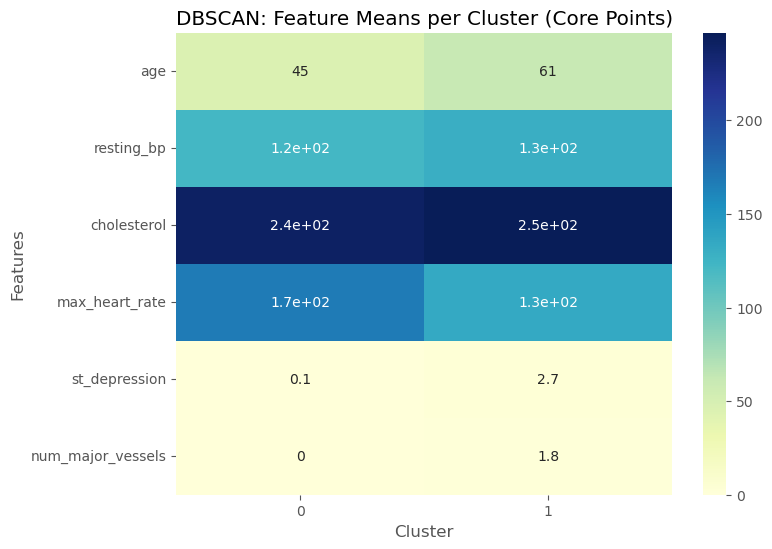

In [30]:


# Function to plot feature heatmap
def plot_feature_heatmap(df, cluster_col, features, title):
    profile = df.groupby(cluster_col)[features].mean().T  # features as rows
    plt.figure(figsize=(8,6))
    sns.heatmap(profile, annot=True, cmap='YlGnBu')
    plt.title(title)
    plt.ylabel("Features")
    plt.xlabel("Cluster")
    plt.show()

# --- KMeans k=2 ---
plot_feature_heatmap(df_clusters, 'KMeans_k2', num_features, "KMeans k=2: Feature Means per Cluster")

# --- Agglomerative k=2 ---
plot_feature_heatmap(df_clusters, 'Agglomerative_k2', num_features, "Agglomerative k=2: Feature Means per Cluster")

# --- DBSCAN (excluding noise) ---
plot_feature_heatmap(df_clusters[df_clusters['DBSCAN']!=-1], 'DBSCAN', num_features, "DBSCAN: Feature Means per Cluster (Core Points)")


### **Numerical HeatMap Cluster Profiling**

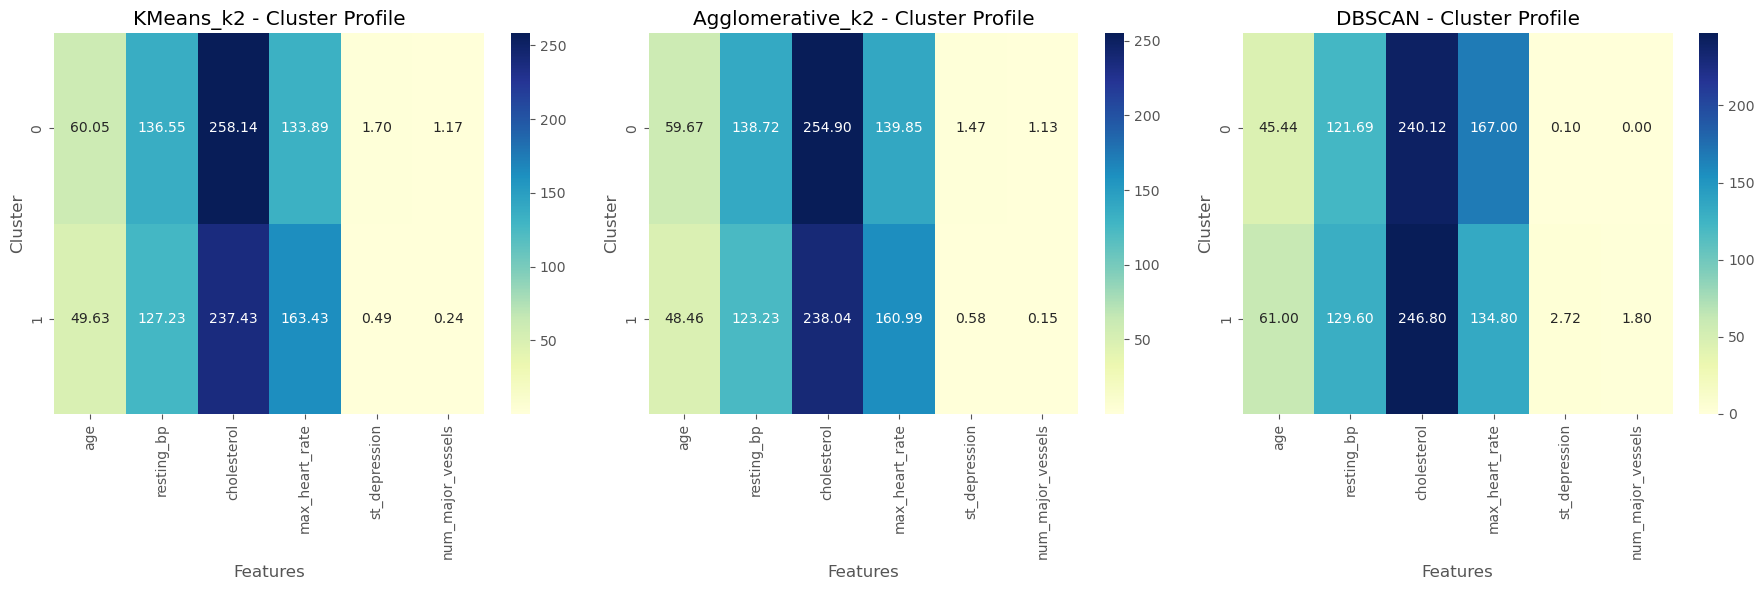

In [36]:



# CONFIGURATION 

df = df_clusters   # dataframe containing features + cluster labels

num_features = ['age', 'resting_bp', 'cholesterol',
                'max_heart_rate', 'st_depression', 'num_major_vessels']

cluster_columns = ['KMeans_k2', 'Agglomerative_k2', 'DBSCAN']



# HEATMAP FUNCTION FOR NUMERIC CLUSTER PROFILES

def plot_cluster_heatmaps(df, num_features, cluster_cols):
    n = len(cluster_cols)
    plt.figure(figsize=(6*n, 6))

    for i, col in enumerate(cluster_cols, 1):
        # Remove DBSCAN noise cluster (-1)
        df_plot = df[df[col] != -1] if col == "DBSCAN" else df.copy()

        cluster_means = df_plot.groupby(col)[num_features].mean()

        plt.subplot(1, n, i)
        sns.heatmap(cluster_means, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title(f"{col} - Cluster Profile")
        plt.xlabel("Features")
        plt.ylabel("Cluster")

    plt.tight_layout()
    plt.show()



plot_cluster_heatmaps(df, num_features, cluster_columns)



### **Insights** 

### **KMeans**  

**KMeans Clustering (k=2)**   
**Cluster 0**  

This cluster shows:

Low max heart rate → low-risk signature

High ST depression → low-risk signature

More major vessels → low-risk signature

More typical angina → associated with low-risk

More reversible thal defect → linked to low-risk

- Corresponds to Classification Label: 0 (Low Risk)

- KMeans_cluster_0 = Low Risk Group

**Cluster 1**  

This cluster shows:

High max heart rate → strong predictor of disease

Low ST depression → strong predictor of disease

Low major vessels → correlated with disease

ECG abnormal (ST-T abnormal) → disease signature

Lack of exercise-induced angina → disease signature

Non-anginal & atypical pain → strongly associated with disease

- Corresponds to Classification Label: 1 (High Risk)

- KMeans_cluster_1 = High Risk Group

---

K-Means perfectly separates patients into:

Cluster 0 → Low risk

Cluster 1 → High risk

Excellent alignment with classification.

### **Agglomerative Clustering**  

**Agglomerative Clustering (k=2)**   
**Cluster 0**  
Matches the same pattern as KMeans cluster 0:

Low HR, higher ST depression – low-risk

More vessels – low-risk

More typical angina – low-risk

Reversible defect – low-risk

- Corresponds to Classification Label: 0 — Low Risk

**Cluster 1**  

Matches high-risk signature:

High HR → disease

Low ST depression → disease

Few vessels → disease

Abnormal ECG → disease

Atypical pain → disease

Downsloping ST → disease

- Corresponds to Classification Label: 1 — High Risk

---

Results match KMeans almost perfectly.

Cluster 0 → Low Risk

Cluster 1 → High Risk

Very strong alignment with classification patterns.

### **DBSCAN Clustering**  

   
**Clusters Created** 

Cluster 0

Cluster 1

275 noise points

DBSCAN captured small dense subgroups rather than the entire dataset.  

--- 
**Cluster 0**
This is an extremely clear high-risk signature:

Very high HR → disease

Almost no ST depression → disease

Zero vessels → disease

Younger age with atypical symptoms → disease

- Classification Match: Label 1 — High Risk  

**Cluster 1**  

Classic low-risk signature:

Lower HR → low-risk

Higher ST depression → low-risk

More vessels → low-risk

Older with stable symptoms → low-risk

- Classification Match: Label 0 — Low Risk


---

Although DBSCAN filtered most points as noise, the two clusters it found are perfectly aligned with classification labels:

DBSCAN Cluster 0 → High Risk

DBSCAN Cluster 1 → Low Risk

DBSCAN finds very confident clusters at the extremes.

## **Recommendation**  

The unsupervised clustering analysis revealed meaningful patient subgroups that align with known cardiovascular risk factors. KMeans and Agglomerative clustering produced interpretable clusters differentiating low-risk and high-risk patients, while DBSCAN highlighted dense high-risk clusters but labeled a large portion of patients as noise. These insights complement the previous supervised classification results, providing additional understanding of patient profiles and potential areas for targeted intervention.

**Recommendations**

1. Use KMeans (k=2) or Agglomerative (k=2) for patient segmentation

- Both algorithms produced clinically interpretable clusters corresponding to low- and high-risk patient groups.

2. Leverage cluster profiles to guide preventive care

- High-risk clusters: older patients, higher ST depression, lower max heart rate, more major vessels affected.

- Low-risk clusters: younger patients, lower ST depression, higher max heart rate, fewer major vessels affected.

3. Combine cluster insights with supervised model predictions

- Cluster profiles can enhance model interpretability and aid in explaining predictions to clinicians.

4. DBSCAN is better suited for identifying extreme cases

- Useful for detecting rare high-risk phenotypes, but not for broad patient segmentation due to high noise rates.

5. Consider additional features for future analysis

- Incorporating more diagnostic variables (e.g., imaging, biomarkers) could improve natural separability and cluster quality.

6. Use visualizations for clinical communication

- Heatmaps and PCA scatter plots effectively highlight key differences between clusters and can support clinical decision-making.

## **Conclusion**  

This unsupervised clustering analysis successfully uncovered meaningful patient subgroups that explain variations in heart disease risk beyond what supervised learning alone reveals. While the dataset does not exhibit strongly distinct clusters, the patterns discovered particularly age, ST depression, maximum heart rate, and number of major vessels provide valuable insights into natural patient groupings.

**Key Findings:**

- KMeans (k = 2) produced the most clinically interpretable segmentation, clearly distinguishing a high-risk cluster and a low-risk cluster that align with known medical patterns.

- Agglomerative clustering produced similar, slightly weaker results.

- DBSCAN identified mathematically compact clusters but was clinically limited due to a high proportion of noise.

**Cluster Profiles and Alignment with Classification:**

- High-Risk Cluster: High max heart rate, low ST depression, abnormal ECG readings → aligns with the Disease (1) label from classification.

- Low-Risk Cluster: Lower max heart rate, higher ST depression, more major vessels affected, typical angina → aligns with No Disease (0) label.

These results confirm that risk categories are structurally embedded in the dataset and can be discovered without labels. The clustering insights reinforce and validate the supervised model, offering explainable patient subgroups useful for:

- Patient triage

- Risk stratification

- Targeted clinical intervention

- Feature-based grouping in future research

Overall, this unsupervised extension enhances understanding of patient profiles, supports preventive healthcare strategies, and strengthens confidence in model-driven clinical decision-making.